In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import scienceplots

In [42]:
plt.style.use(['science'])

In [3]:
results_dir = "../results"
dataset_dir = "../datasets/lacbed"
splits_dir = "../data/FDP_splits"

sg = pd.read_csv("space_groups.csv")

groups = set(sg["space_group"].to_list())

differences = {group: np.zeros((128, 128)) for group in groups}
differences_counts = {group: 0 for group in groups}

for seed in (os.listdir(results_dir)):
    direction = seed.split("_")[0]
    if direction != "pattern":
        break

    outputs = os.listdir(os.path.join(results_dir, seed))
    
    for output in outputs:
        
        phase, epoch = output.split("_")
        
        if phase == "train" or epoch != "100":
            continue

        print("analysing", seed, phase, epoch)

        rms = 0
        for image in os.listdir(os.path.join(results_dir, seed, output, "images")):
            
            code = image.split("_")[0]
            
            fake = cv2.cvtColor(cv2.imread(
                os.path.join(results_dir, seed, output, "images", image)
            ), cv2.COLOR_BGR2GRAY) / 255
            real = cv2.cvtColor(cv2.imread(
                os.path.join(dataset_dir, code, code + "_+0+0+0.png")
            ), cv2.COLOR_BGR2GRAY) / 255
            
            group = sg.loc[sg['ICSD_code'] == int(code), 'space_group'].iloc[0]
            
            diff = (real - fake)**2
            
            differences[group] += diff
            differences_counts[group] += 1

for group in groups:
    differences[group] /= differences_counts[group]

analysing pattern_random0 test 100
analysing pattern_random0 val 100
analysing pattern_random1 test 100
analysing pattern_random1 val 100
analysing pattern_random2 test 100
analysing pattern_random2 val 100
analysing pattern_random3 test 100
analysing pattern_random3 val 100
analysing pattern_random4 test 100
analysing pattern_random4 val 100
analysing pattern_random5 test 100
analysing pattern_random5 val 100
analysing pattern_random6 test 100
analysing pattern_random6 val 100
analysing pattern_random7 test 100
analysing pattern_random7 val 100
analysing pattern_random8 test 100
analysing pattern_random8 val 100
analysing pattern_random9 test 100
analysing pattern_random9 val 100


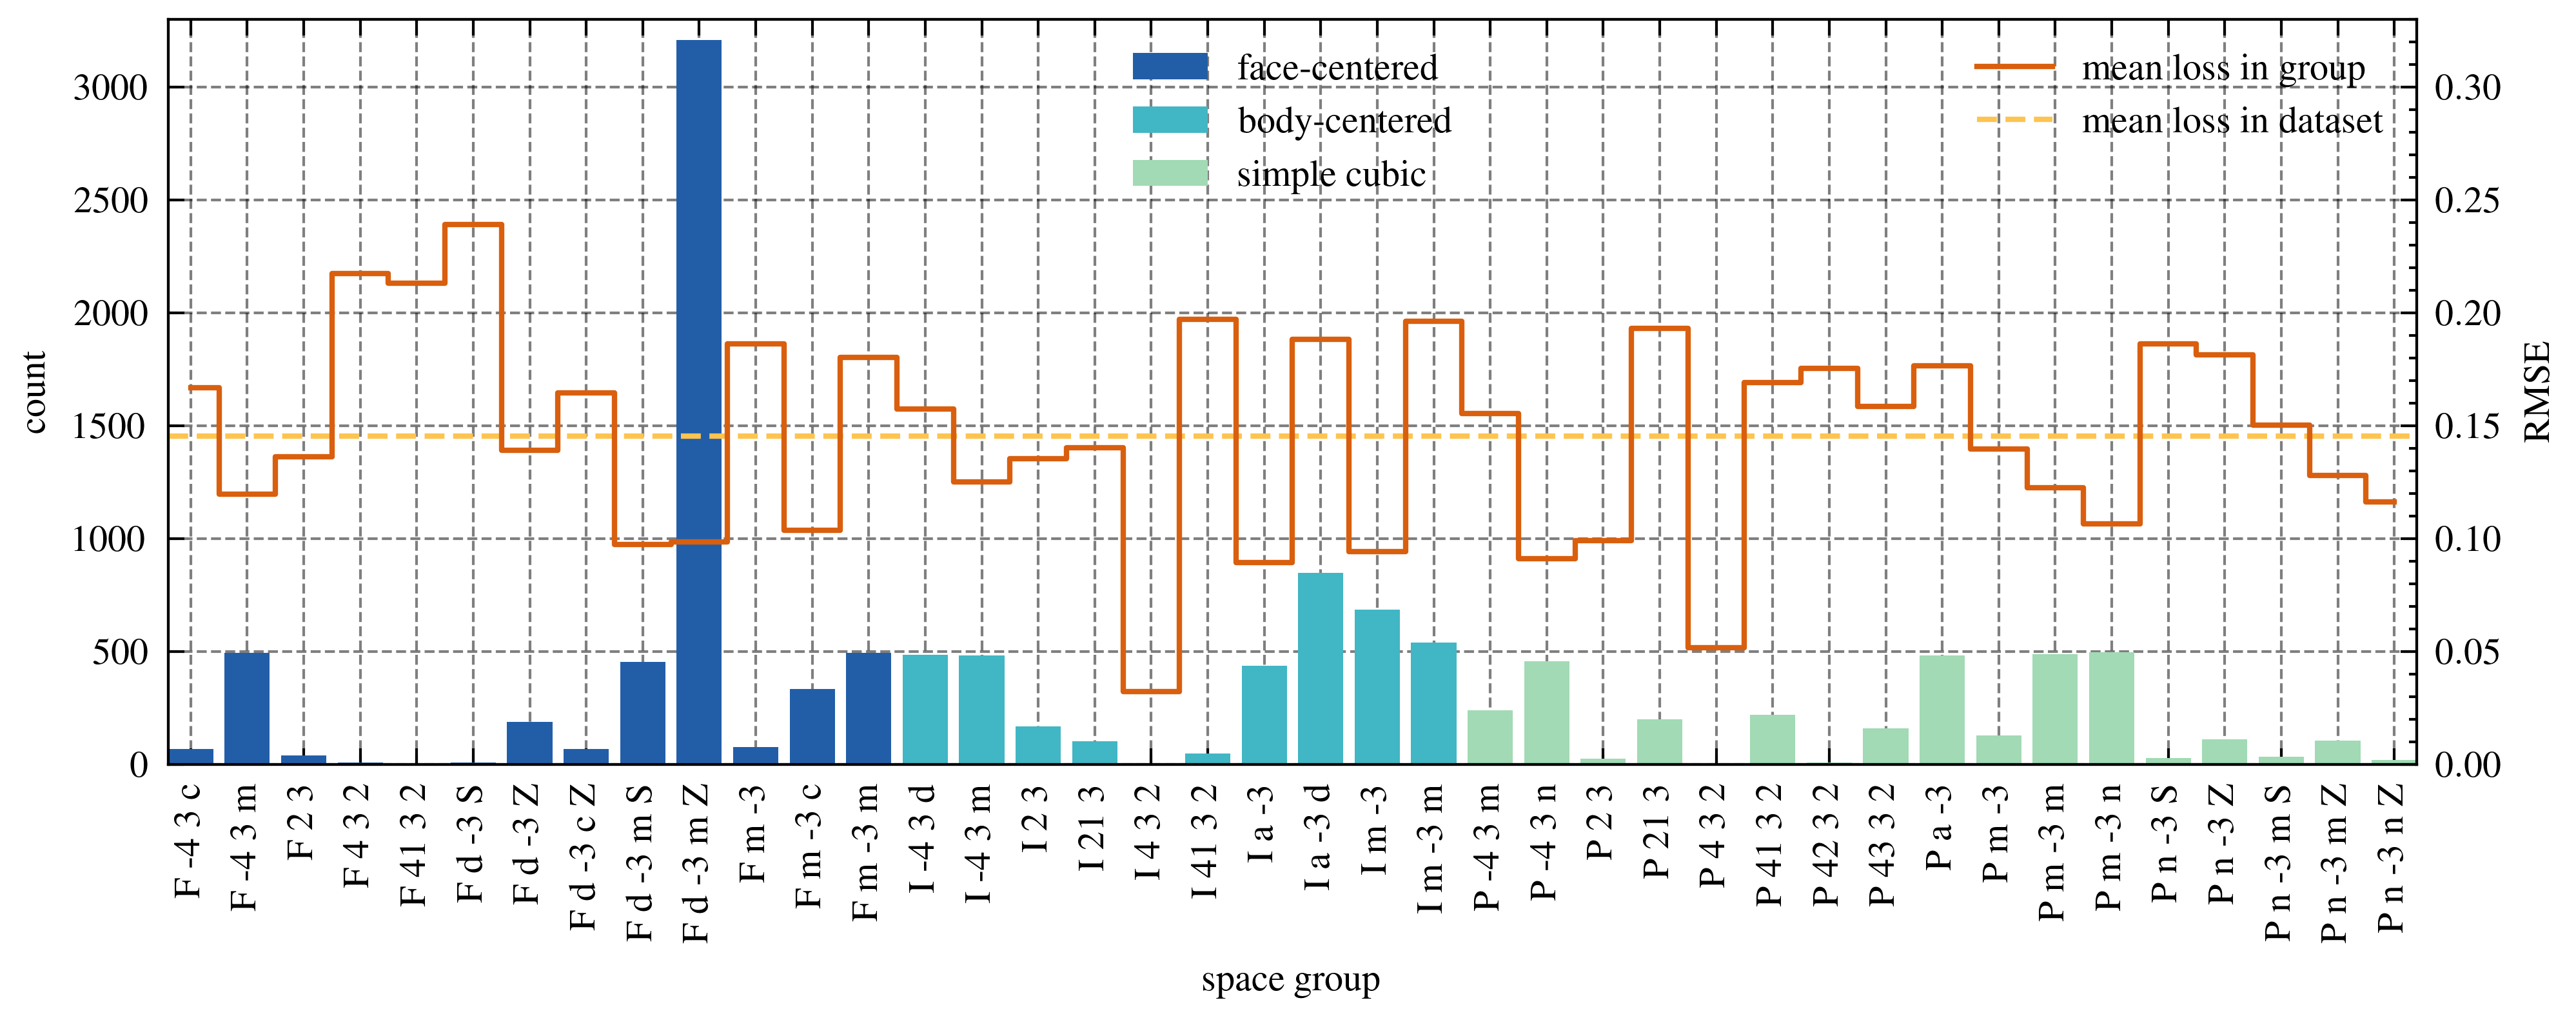

In [43]:
df = pd.read_csv("space_groups.csv")
df.index.name = "index"

df_count = df.groupby(["space_group"]).count().reset_index()
df_count2 = df_count["space_group"].astype(str).str[0].reset_index()

losses_by_group = dict()
for group in differences.keys():
    losses_by_group[group] = [np.sqrt(np.mean(differences[group]))]
df_losses_by_group = pd.DataFrame.from_dict(losses_by_group).transpose()
df_losses_by_group.columns = ["RMSE"]
df_losses_by_group.sort_index(inplace=True)

fig, ax = plt.subplots(figsize=(7.5, 2.5))

plt.xticks(rotation='vertical')
plt.minorticks_off()
pparam = dict(xlabel=r'space group', ylabel=r'count')

ax.bar(df_count.loc[df_count2["space_group"] == "F"]["space_group"], df_count.loc[df_count2["space_group"] == "F"]["ICSD_code"], label="face-centered", color="#225EA8")
ax.bar(df_count.loc[df_count2["space_group"] == "I"]["space_group"], df_count.loc[df_count2["space_group"] == "I"]["ICSD_code"], label="body-centered", color="#41B6C4")
ax.bar(df_count.loc[df_count2["space_group"] == "P"]["space_group"], df_count.loc[df_count2["space_group"] == "P"]["ICSD_code"], label="simple cubic", color="#A1DAB4")
ax.set_ylim([0, 3300])
plt.margins(0, 0)

pparam2 = dict(ylabel=r'RMSE')
ax2 = ax.twinx()

ax2.step(df_losses_by_group.index, df_losses_by_group.RMSE, where="mid", zorder=4, label="mean loss in group", color="#D95F0E")
ax2.axhline(df_losses_by_group.mean().iloc[0], label="mean loss in dataset", color="#FEC44F", linestyle="dashed")

ax2.set_ylim([0, 0.33])
plt.margins(0, 0.)


ax2.legend(loc="upper right")
ax.legend(loc="upper center")
ax2.grid(False)

ax.set(**pparam)
ax2.set(**pparam2)
fig.savefig('figures/space_groups', dpi=1200)

In [ ]:
fig, ax = plt.subplots(figsize=(7.5, 2.5))